In [1]:
# --- Environment setup and imports ---

import os, sys
from pathlib import Path

root = Path("../..").resolve()   
sys.path.append(str(root))

# sanity check
print("Project root:", root)

# --- Core libraries ---
import copy
import random
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

# --- Default parameters (used in old loop or new config overrides) ---
number_of_clients = 3
number_of_rounds = 5

Project root: /Users/christophbout/Library/Mobile Documents/com~apple~CloudDocs/FH/5. Semester/Capstone Innovation Project/Code/Sec_Federated_Learning/Sec_Federated_Learning


In [2]:
from src.utils.config_utils import load_config, normalize_config
from src.utils.exp_utils import compute_exp_id, ensure_exp_dirs
from src.utils.logging_utils import JsonlLogger, get_git_commit
from src.orchestrator.pipeline import run_training_rounds

In [3]:
# --- Configure experiment (edit as needed) ---
overrides = [
    "model.name=smallcnn",
    "data.partition=iid",
    "data.num_clients=5",
    "data.clients_per_round=3",
    "training.rounds=2",
    "training.local_epochs=1",
    "training.batch_size=64",
    "training.lr=0.01",
    "encryption.scheme=dp_selective",
    "encryption.layers=L1",
    "encryption.noise_multiplier=0.5",
    "encryption.clip_norm=1.0",
]

cfg = load_config("../../configs/config.yaml", overrides)
cfg["commit"] = get_git_commit()
cfg

{'defaults': [],
 'project': {'name': 'dp_fedlearn', 'output_dir': 'reports'},
 'seed': 1,
 'commit': '6da5b815a7a607ac74d759cd6de907acd9a8ac0b',
 'data': {'dataset': 'CIFAR10',
  'num_clients': 5,
  'clients_per_round': 3,
  'partition': 'iid',
  'dirichlet_alpha': 0.5},
 'model': {'name': 'smallcnn', 'num_classes': 10},
 'training': {'rounds': 2,
  'local_epochs': 1,
  'batch_size': 64,
  'lr': 0.01,
  'optimizer': 'sgd'},
 'encryption': {'scheme': 'dp_selective',
  'layers': 'L1',
  'noise_multiplier': 0.5,
  'clip_norm': 1.0,
  'secure_aggregation': False},
 'attack': {'name': 'yin', 'recon_per_client': 8, 'max_iters': 1000},
 'logging': {'to_jsonl': True,
  'to_mlflow': False,
  'mlflow_tracking_uri': None,
  'level': 'INFO'},
 'orchestration': {'exp_id': None}}

In [4]:
exp_id = compute_exp_id(normalize_config(cfg))
exp_root = ensure_exp_dirs(cfg["project"]["output_dir"], exp_id)

logger = JsonlLogger(
    exp_root / "train.jsonl",
    extra={"exp_id": exp_id, "commit": cfg["commit"], "seed": cfg["seed"]},
)

print(f"Experiment ID: {exp_id}")
print(f"Output folder: {exp_root}")

Experiment ID: b2e9d51752a2e71e
Output folder: reports/b2e9d51752a2e71e


In [5]:
from src.attacks.yin_attack import YinReconstructionAttack
from pathlib import Path
import torch

attack = YinReconstructionAttack()
dummy_model = torch.nn.Linear(10, 10)
attack.reconstruct(dummy_model, Path("test_recon"))

results = run_training_rounds(cfg, exp_root, logger)
print("Results:", results)

[YinAttack] Placeholder reconstruction saved to test_recon/reconstructed.pt
[YinAttack] Placeholder reconstruction saved to reports/b2e9d51752a2e71e/recon/reconstructed.pt
Results: {'top1': 0.095, 'privacy': {'psnr': 30.0, 'ssim': 0.3, 'lpips': 0.7}}


,ts,level,event,exp_id,commit,seed,round,top1,bytes_up,bytes_down,time_s
0,2025-10-28T08:36:08.063333Z,INFO,round_end,b2e9d51752a2e71e,6da5b815a7a607ac74d759cd6de907acd9a8ac0b,1,0,0.1498,123456,654321,25.645125
1,2025-10-28T08:36:33.833633Z,INFO,round_end,b2e9d51752a2e71e,6da5b815a7a607ac74d759cd6de907acd9a8ac0b,1,1,0.1140,123456,654321,25.770168
2,2025-10-28T08:42:17.129481Z,INFO,round_end,b2e9d51752a2e71e,6da5b815a7a607ac74d759cd6de907acd9a8ac0b,1,0,0.0939,123456,654321,25.230159
3,2025-10-28T08:42:42.442154Z,INFO,round_end,b2e9d51752a2e71e,6da5b815a7a607ac74d759cd6de907acd9a8ac0b,1,1,0.1658,123456,654321,25.311841
4,2025-10-28T08:47:44.581692Z,INFO,round_end,b2e9d51752a2e71e,6da5b815a7a607ac74d759cd6de907acd9a8ac0b,1,0,0.1229,123456,654321,25.634329
5,2025-10-28T08:48:10.373202Z,INFO,round_end,b2e9d51752a2e71e,6da5b815a7a607ac74d759cd6de907acd9a8ac0b,1,1,0.0950,123456,654321,25.790685


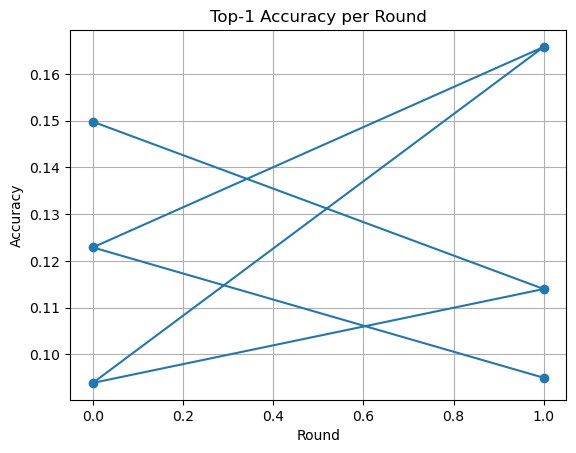

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

train_log = pd.read_json(exp_root / "train.jsonl", lines=True)
display(train_log)

plt.plot(train_log["round"], train_log["top1"], marker="o")
plt.title("Top-1 Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()